In [12]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [14]:
def cbam_block(inputs, reduction=16):
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    shared_dense = layers.Dense(inputs.shape[-1] // reduction, activation='relu')
    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    channel = layers.Add()([avg_out, max_out])
    channel = layers.Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel = layers.Reshape((1, 1, inputs.shape[-1]))(channel)
    x = layers.Multiply()([inputs, channel])
    avg_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_spatial, max_spatial])
    spatial = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, spatial])

In [15]:
def crm_block(x):
    edge = tf.image.sobel_edges(x)
    edge_mean = tf.reduce_mean(edge, axis=-1, keepdims=True)
    stat_mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    stat_mean = tf.tile(stat_mean, [1, x.shape[1], x.shape[2], 1])
    x_cat = layers.Concatenate(axis=-1)([edge_mean[..., 0], stat_mean])
    attention = layers.Conv2D(x.shape[-1], (1, 1), activation='sigmoid')(x_cat)
    return layers.Multiply()([x, attention])

In [16]:
def build_model(input_shape=(224, 224, 3), num_classes=4, use_vit=False):
    inp = Input(shape=input_shape)
    base = DenseNet121(include_top=False, weights='imagenet', input_tensor=inp)
    for layer in base.layers:
        layer.trainable = False
    x = base.output
    x = cbam_block(x)
    x = crm_block(x)
    if use_vit:
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        xflat = layers.Reshape((H * W, C))(x)
        att = layers.MultiHeadAttention(num_heads=4, key_dim=C // 4)(xflat, xflat)
        x = layers.GlobalAveragePooling1D()(att)
    else:
        x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inp, outputs=out)

In [17]:
def create_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size,
                                                        batch_size=batch_size, class_mode='categorical')
    val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=target_size,
                                                         batch_size=batch_size, class_mode='categorical')
    test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=target_size,
                                                          batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator, test_generator

In [18]:
def train_model(model, train_gen, val_gen, epochs=30):
    model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
                  loss=SigmoidFocalCrossEntropy(),
                  metrics=['accuracy'])
    callbacks = [
        EarlyStopping(patience=8, restore_best_weights=True),
        ReduceLROnPlateau(patience=4, factor=0.5),
        ModelCheckpoint("EyeNet_Latest_Model.h5", save_best_only=True)
    ]
    return model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)

In [19]:
def fine_tune_model(model, train_gen, val_gen, epochs=10):
    model.trainable = True
    model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
                  loss=SigmoidFocalCrossEntropy(),
                  metrics=['accuracy'])
    return model.fit(train_gen, validation_data=val_gen, epochs=epochs)


In [20]:
def evaluate_model(model, test_gen):
    loss, acc = model.evaluate(test_gen)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap='Blues'); plt.title("Confusion Matrix"); plt.colorbar()
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

In [21]:
def main():
    set_seed()
    base_dir = r'C:\Users\User\Desktop\dataset_split'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')
    train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir)
    model = build_model(use_vit=False)
    train_model(model, train_gen, val_gen)
    fine_tune_model(model, train_gen, val_gen)
    evaluate_model(model, test_gen)
    model.save("EyeNet_Model_2025_Enhanced.h5")
    print("Model saved.")

Found 7490 images belonging to 4 classes.
Found 1499 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Epoch 1/30
235/235 [==============================] - 45s 181ms/step - loss: 0.1629 - accuracy: 0.6105 - val_loss: 0.1097 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 2/30
235/235 [==============================] - 43s 184ms/step - loss: 0.1129 - accuracy: 0.7721 - val_loss: 0.0912 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 3/30
235/235 [==============================] - 43s 181ms/step - loss: 0.0960 - accuracy: 0.8160 - val_loss: 0.0810 - val_accuracy: 0.8492 - lr: 0.0010
Epoch 4/30
235/235 [==============================] - 41s 173ms/step - loss: 0.0834 - accuracy: 0.8406 - val_loss: 0.0726 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 5/30
235/235 [==============================] - 40s 170ms/step - loss: 0.0738 - accuracy: 0.8614 - val_loss: 0.0675 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 6/30
235/235 [==============================] - 40s 171ms/step - loss: 0.0677 

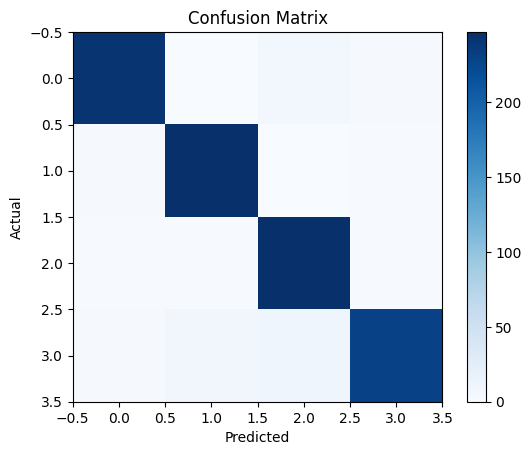

Model saved.


In [22]:
if __name__ == '__main__':
    main()